In [11]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
from sklearn import datasets

In [6]:
bcancer = datasets.load_breast_cancer()
X = bcancer.data  
y = bcancer.target
X = StandardScaler().fit_transform(X)

In [7]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(212, 30)
(357, 30)


In [8]:
indices=np.arange(106)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:106]
x_train=np.concatenate((np.array(x_neg[0:106])[indices],x_pos)).reshape(-1,30)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [9]:
x_test = x_neg[106:212].reshape(-1,30)
y_test = y_neg[106:212].reshape(-1,1)

# Projection model

In [12]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [13]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [58]:
num_of_iterations = 50 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.396226 - Time Taken to create filter(sec): 0.102308 



Size: 20 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.092280 



Size: 30 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.095095 



Size: 40 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.113087 



Size: 50 Bits - FPR: 0.349057 - Time Taken to create filter(sec): 0.104781 



Size: 60 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.108577 



Size: 70 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.110470 



Size: 80 Bits - FPR: 0.301887 - Time Taken to create filter(sec): 0.107374 



Size: 90 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.100694 



Size: 100 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.102793 



Size: 110 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.099254 



Size: 120 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.102244 



Size: 1


Size: 1030 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.096667 



Size: 1040 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.090358 



Size: 1050 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.088470 



Size: 1060 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.086173 



Size: 1070 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.093557 



Size: 1080 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.088012 



Size: 1090 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.090688 



Size: 1100 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.105575 



Size: 1110 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.093938 



Size: 1120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087489 



Size: 1130 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.110132 



Size: 1140 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.087072 



Size: 1150 Bits - FPR: 0.06

Size: 2050 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.097585 



Size: 2060 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.096039 



Size: 2070 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.108528 



Size: 2080 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.124222 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109380 



Size: 2100 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.110608 



Size: 2110 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.109059 



Size: 2120 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.108876 



Size: 2130 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.106683 



Size: 2140 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.110547 



Size: 2150 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.142839 



Size: 2160 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.111606 



Size: 2170 Bits - FPR: 0.047

Size: 60 Bits - FPR: 0.415094 - Time Taken to create filter(sec): 0.106711 



Size: 70 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.100251 



Size: 80 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.099618 



Size: 90 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.099310 



Size: 100 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.097840 



Size: 110 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.102896 



Size: 120 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.099713 



Size: 130 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.104227 



Size: 140 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.096771 



Size: 150 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.103266 



Size: 160 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.099886 



Size: 170 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.104992 



Size: 180 Bits - FPR: 0.132075 - Time Taken 

Size: 1090 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.088455 



Size: 1100 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.089744 



Size: 1110 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.089851 



Size: 1120 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.098124 



Size: 1130 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.087359 



Size: 1140 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.089844 



Size: 1150 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.085970 



Size: 1160 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.089024 



Size: 1170 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.092689 



Size: 1180 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.089717 



Size: 1190 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.087347 



Size: 1200 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.091295 



Size: 1210 Bits - FPR: 0.028

Size: 2120 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.121726 



Size: 2130 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111479 



Size: 2140 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.112345 



Size: 2150 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.111511 



Size: 2160 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.113158 



Size: 2170 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.108618 



Size: 2180 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.120666 



Size: 2190 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109213 



Size: 2200 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113212 



Size: 2210 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.110029 



Size: 2220 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109697 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109934 



Size: 2240 Bits - FPR: 0.028


Size: 140 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096090 



Size: 150 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.100940 



Size: 160 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.109920 



Size: 170 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.104798 



Size: 180 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.098472 



Size: 190 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.096690 



Size: 200 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.097502 



Size: 210 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.096562 



Size: 220 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.099612 



Size: 230 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.098790 



Size: 240 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.098606 



Size: 250 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.096962 



Size: 260 Bits - FPR: 0.264151 - Time T

Size: 1180 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.086583 



Size: 1190 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.089221 



Size: 1200 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.088334 



Size: 1210 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.087806 



Size: 1220 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.098110 



Size: 1230 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.090853 



Size: 1240 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.086583 



Size: 1250 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.087597 



Size: 1260 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.088136 



Size: 1270 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.088960 



Size: 1280 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.087817 



Size: 1290 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.089368 



Size: 1300 Bits - FPR: 0.066

Size: 2210 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.108457 



Size: 2220 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.108879 



Size: 2230 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111385 



Size: 2240 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.110939 



Size: 2250 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113281 



Size: 2260 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.108349 



Size: 2270 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109411 



Size: 2280 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.108869 



Size: 2290 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110150 



Size: 2300 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.115396 



Size: 2310 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.111073 



Size: 2320 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113928 



Size: 2330 Bits - FPR: 0.018


Size: 240 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.104818 



Size: 250 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.100228 



Size: 260 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.094790 



Size: 270 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.091445 



Size: 280 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.093339 



Size: 290 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.102287 



Size: 300 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.096505 



Size: 310 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.096569 



Size: 320 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.098293 



Size: 330 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.099284 



Size: 340 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.099366 



Size: 350 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.100535 



Size: 360 Bits - FPR: 0.094340 - Time T

Size: 1290 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.091197 



Size: 1300 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.087192 



Size: 1310 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.087794 



Size: 1320 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.092684 



Size: 1330 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.088149 



Size: 1340 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.090903 



Size: 1350 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.087056 



Size: 1360 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.086154 



Size: 1370 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.087944 



Size: 1380 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.088853 



Size: 1390 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.087515 



Size: 1400 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.088331 



Size: 1410 Bits - FPR: 0.018

Size: 2320 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.111199 



Size: 2330 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.137190 



Size: 2340 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111801 



Size: 2350 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.110474 



Size: 2360 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.113761 



Size: 2370 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109940 



Size: 2380 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.119330 



Size: 2390 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.114534 



Size: 2400 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.116073 



Size: 2410 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.114088 



Size: 2420 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.119901 



Size: 2430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130777 



Size: 2440 Bits - FPR: 0.056


Size: 350 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.100410 



Size: 360 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.104178 



Size: 370 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.099888 



Size: 380 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.097383 



Size: 390 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.097886 



Size: 400 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.104458 



Size: 410 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.098138 



Size: 420 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.109733 



Size: 430 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105757 



Size: 440 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.102424 



Size: 450 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.101508 



Size: 460 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.102312 



Size: 470 Bits - FPR: 0.103774 - Time T

Size: 1390 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.086303 



Size: 1400 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.085416 



Size: 1410 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.086787 



Size: 1420 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.085508 



Size: 1430 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.087493 



Size: 1440 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.090779 



Size: 1450 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.087003 



Size: 1460 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.086925 



Size: 1470 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.086616 



Size: 1480 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.086391 



Size: 1490 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.086842 



Size: 1500 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.088951 



Size: 1510 Bits - FPR: 0.000

Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111561 



Size: 2420 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109673 



Size: 2430 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.112678 



Size: 2440 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.138798 



Size: 2450 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.109364 



Size: 2460 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.110954 



Size: 2470 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.108303 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131183 



Size: 2490 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.109888 



Size: 2500 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.109289 



Size: 2510 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.110310 



Size: 2520 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110382 



Size: 2530 Bits - FPR: 0.028

Size: 440 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.103854 



Size: 450 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.104034 



Size: 460 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105087 



Size: 470 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105211 



Size: 480 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.113851 



Size: 490 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.106390 



Size: 500 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103402 



Size: 510 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.100480 



Size: 520 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.101523 



Size: 530 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101187 



Size: 540 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.102017 



Size: 550 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.103245 



Size: 560 Bits - FPR: 0.160377 - Time Ta

Size: 1480 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.087542 



Size: 1490 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.086593 



Size: 1500 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.088724 



Size: 1510 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.086221 



Size: 1520 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.087139 



Size: 1530 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.087847 



Size: 1540 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.086657 



Size: 1550 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101821 



Size: 1560 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.101576 



Size: 1570 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.100055 



Size: 1580 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.107187 



Size: 1590 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.103832 



Size: 1600 Bits - FPR: 0.037

Size: 2510 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.122638 



Size: 2520 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.110445 



Size: 2530 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.111642 



Size: 2540 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.109342 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110566 



Size: 2560 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.112720 



Size: 2570 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.110861 



Size: 2580 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.154921 



Size: 2590 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.133192 



Size: 2600 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121482 



Size: 2610 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121172 



Size: 2620 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.122488 



Size: 2630 Bits - FPR: 0.009


Size: 540 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.101891 



Size: 550 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103772 



Size: 560 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.103169 



Size: 570 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.106750 



Size: 580 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.114528 



Size: 590 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.106018 



Size: 600 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.106150 



Size: 610 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.106068 



Size: 620 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.101722 



Size: 630 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.101056 



Size: 640 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103213 



Size: 650 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103668 



Size: 660 Bits - FPR: 0.103774 - Time T

Size: 1570 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.107012 



Size: 1580 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103183 



Size: 1590 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.103287 



Size: 1600 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101867 



Size: 1610 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.100376 



Size: 1620 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.102904 



Size: 1630 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.101721 



Size: 1640 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.099112 



Size: 1650 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101780 



Size: 1660 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.103454 



Size: 1670 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.101347 



Size: 1680 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.104615 



Size: 1690 Bits - FPR: 0.056

Size: 2600 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.128420 



Size: 2610 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.122494 



Size: 2620 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.127842 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128648 



Size: 2640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.122320 



Size: 2650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.151931 



Size: 2660 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.125522 



Size: 2670 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.121453 



Size: 2680 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.121487 



Size: 2690 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.120944 



Size: 2700 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.124142 



Size: 2710 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.124482 



Size: 2720 Bits - FPR: 0.037

Size: 620 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.109268 



Size: 630 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.101590 



Size: 640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.099695 



Size: 650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.105650 



Size: 660 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.100693 



Size: 670 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105791 



Size: 680 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.102751 



Size: 690 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103179 



Size: 700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103854 



Size: 710 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.103285 



Size: 720 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.107783 



Size: 730 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107045 



Size: 740 Bits - FPR: 0.103774 - Time Ta

Size: 1650 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.105931 



Size: 1660 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.105309 



Size: 1670 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.105395 



Size: 1680 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.098398 



Size: 1690 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.129839 



Size: 1700 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.100769 



Size: 1710 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.098559 



Size: 1720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.100949 



Size: 1730 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.101979 



Size: 1740 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.102618 



Size: 1750 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107072 



Size: 1760 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103879 



Size: 1770 Bits - FPR: 0.037

Size: 2680 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.129764 



Size: 2690 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.129883 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124903 



Size: 2710 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.131514 



Size: 2720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.128201 



Size: 2730 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.126124 



Size: 2740 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125478 



Size: 2750 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.130291 



Size: 2760 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.134784 



Size: 2770 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.130204 



Size: 2780 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.135592 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133722 



Size: 2800 Bits - FPR: 0.018

Size: 710 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.106845 



Size: 720 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.102407 



Size: 730 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.103843 



Size: 740 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.103901 



Size: 750 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.104245 



Size: 760 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.104500 



Size: 770 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.099364 



Size: 780 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.100261 



Size: 790 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.100949 



Size: 800 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.106136 



Size: 810 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.106436 



Size: 820 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.107072 



Size: 830 Bits - FPR: 0.028302 - Time Ta

Size: 1730 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105818 



Size: 1740 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.105810 



Size: 1750 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101803 



Size: 1760 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.105681 



Size: 1770 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.116591 



Size: 1780 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.106665 



Size: 1790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.118555 



Size: 1800 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.101005 



Size: 1810 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110546 



Size: 1820 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.105113 



Size: 1830 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.112500 



Size: 1840 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.103048 



Size: 1850 Bits - FPR: 0.000

Size: 2760 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.133921 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127643 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128419 



Size: 2790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.124994 



Size: 2800 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.128799 



Size: 2810 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.128519 



Size: 2820 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.132820 



Size: 2830 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.136254 



Size: 2840 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.129038 



Size: 2850 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.124983 



Size: 2860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.128794 



Size: 2870 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.133097 



Size: 2880 Bits - FPR: 0.000

Size: 780 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109166 



Size: 790 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.107167 



Size: 800 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.106065 



Size: 810 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105707 



Size: 820 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.103290 



Size: 830 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.106112 



Size: 840 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.104373 



Size: 850 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.101840 



Size: 860 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.102705 



Size: 870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.102187 



Size: 880 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.104533 



Size: 890 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.103015 



Size: 900 Bits - FPR: 0.075472 - Time Ta

Size: 1810 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112929 



Size: 1820 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.100441 



Size: 1830 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.103209 



Size: 1840 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.129064 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107951 



Size: 1860 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101378 



Size: 1870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.100572 



Size: 1880 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.103292 



Size: 1890 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.100462 



Size: 1900 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.104986 



Size: 1910 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.128429 



Size: 1920 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.104280 



Size: 1930 Bits - FPR: 0.009

Size: 2830 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124599 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122305 



Size: 2850 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125227 



Size: 2860 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.127385 



Size: 2870 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.145171 



Size: 2880 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.124973 



Size: 2890 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.124228 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122259 



Size: 2910 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125287 



Size: 2920 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.123239 



Size: 2930 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.127577 



Size: 2940 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.118154 



Size: 2950 Bits - FPR: 0.028

Size: 860 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.104552 



Size: 870 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.100970 



Size: 880 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.098889 



Size: 890 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.099578 



Size: 900 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.098967 



Size: 910 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.109962 



Size: 920 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.110709 



Size: 930 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096798 



Size: 940 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.100551 



Size: 950 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.105349 



Size: 960 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.103750 



Size: 970 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.104671 



Size: 980 Bits - FPR: 0.037736 - Time Ta

Size: 1890 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101017 



Size: 1900 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101805 



Size: 1910 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.102701 



Size: 1920 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104025 



Size: 1930 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102857 



Size: 1940 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.104259 



Size: 1950 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.104252 



Size: 1960 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.102507 



Size: 1970 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102295 



Size: 1980 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.099228 



Size: 1990 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105238 



Size: 2000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.102060 



Size: 2010 Bits - FPR: 0.066

Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124993 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125410 



Size: 2930 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.125771 



Size: 2940 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.128631 



Size: 2950 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.122015 



Size: 2960 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.126242 



Size: 2970 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125722 



Size: 2980 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.126397 



Size: 2990 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.121738 



Size: 3000 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.122037 



~~~~~~~~ Iteration 12 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.481132 - Time Taken to create filter(sec): 0.112409 



Size: 20 Bits - FPR: 0.547170 - Time Taken to create filter(sec): 0.

Size: 930 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.108293 



Size: 940 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.095221 



Size: 950 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.096362 



Size: 960 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.099964 



Size: 970 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101126 



Size: 980 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.100367 



Size: 990 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103568 



Size: 1000 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105721 



Size: 1010 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.110136 



Size: 1020 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.112224 



Size: 1030 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.107028 



Size: 1040 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.096810 



Size: 1050 Bits - FPR: 0.037736 - T

Size: 1950 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.107863 



Size: 1960 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.121913 



Size: 1970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101607 



Size: 1980 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.107588 



Size: 1990 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105892 



Size: 2000 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102330 



Size: 2010 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103176 



Size: 2020 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.121051 



Size: 2030 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107198 



Size: 2040 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.099793 



Size: 2050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121222 



Size: 2060 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.101760 



Size: 2070 Bits - FPR: 0.028

Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124233 



Size: 2980 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.128190 



Size: 2990 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125600 



Size: 3000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125149 



~~~~~~~~ Iteration 13 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.111218 



Size: 20 Bits - FPR: 0.575472 - Time Taken to create filter(sec): 0.105158 



Size: 30 Bits - FPR: 0.301887 - Time Taken to create filter(sec): 0.108841 



Size: 40 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.107918 



Size: 50 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.110384 



Size: 60 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.108123 



Size: 70 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.112322 



Size: 80 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.106577 



S

Size: 990 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.104513 



Size: 1000 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.103562 



Size: 1010 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.101611 



Size: 1020 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109054 



Size: 1030 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.110569 



Size: 1040 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.089326 



Size: 1050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119077 



Size: 1060 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.089119 



Size: 1070 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.116286 



Size: 1080 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.117239 



Size: 1090 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.120267 



Size: 1100 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.111394 



Size: 1110 Bits - FPR: 0.0566

Size: 2010 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.109764 



Size: 2020 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.102998 



Size: 2030 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.104795 



Size: 2040 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.102671 



Size: 2050 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.106348 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139609 



Size: 2070 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.119742 



Size: 2080 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.118075 



Size: 2090 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.118160 



Size: 2100 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.125077 



Size: 2110 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.114640 



Size: 2120 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.119465 



Size: 2130 Bits - FPR: 0.084

Size: 30 Bits - FPR: 0.433962 - Time Taken to create filter(sec): 0.117722 



Size: 40 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.105795 



Size: 50 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.104575 



Size: 60 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.107344 



Size: 70 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.106144 



Size: 80 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.108261 



Size: 90 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.101991 



Size: 100 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.104568 



Size: 110 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.105346 



Size: 120 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.111698 



Size: 130 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.108730 



Size: 140 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.106326 



Size: 150 Bits - FPR: 0.254717 - Time Taken to 

Size: 1080 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.090664 



Size: 1090 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.092445 



Size: 1100 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.098748 



Size: 1110 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.090985 



Size: 1120 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.092391 



Size: 1130 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.092344 



Size: 1140 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.089862 



Size: 1150 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.092466 



Size: 1160 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.094775 



Size: 1170 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.090553 



Size: 1180 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.095730 



Size: 1190 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.094970 



Size: 1200 Bits - FPR: 0.103

Size: 2100 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.111139 



Size: 2110 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.107903 



Size: 2120 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.115819 



Size: 2130 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111799 



Size: 2140 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.115610 



Size: 2150 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.140450 



Size: 2160 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.114470 



Size: 2170 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.107518 



Size: 2180 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.110820 



Size: 2190 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.110213 



Size: 2200 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111080 



Size: 2210 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.115251 



Size: 2220 Bits - FPR: 0.028

Size: 110 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.105443 



Size: 120 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.110984 



Size: 130 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.110064 



Size: 140 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.109660 



Size: 150 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.106043 



Size: 160 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.106886 



Size: 170 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.113734 



Size: 180 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.108772 



Size: 190 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.105495 



Size: 200 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.101362 



Size: 210 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.101795 



Size: 220 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.104786 



Size: 230 Bits - FPR: 0.132075 - Time Ta

Size: 1150 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.090123 



Size: 1160 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.092868 



Size: 1170 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.094950 



Size: 1180 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.098437 



Size: 1190 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.094726 



Size: 1200 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.094825 



Size: 1210 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.091203 



Size: 1220 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.091730 



Size: 1230 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107504 



Size: 1240 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.090127 



Size: 1250 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.093027 



Size: 1260 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.097104 



Size: 1270 Bits - FPR: 0.056

Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120978 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113385 



Size: 2200 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.118335 



Size: 2210 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.116943 



Size: 2220 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.118279 



Size: 2230 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.110409 



Size: 2240 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.118445 



Size: 2250 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.121140 



Size: 2260 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.120948 



Size: 2270 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.115806 



Size: 2280 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.115965 



Size: 2290 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.119625 



Size: 2300 Bits - FPR: 0.009

Size: 200 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.107922 



Size: 210 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.104143 



Size: 220 Bits - FPR: 0.349057 - Time Taken to create filter(sec): 0.105449 



Size: 230 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103628 



Size: 240 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.105712 



Size: 250 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.103556 



Size: 260 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.103201 



Size: 270 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.104060 



Size: 280 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107419 



Size: 290 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.106924 



Size: 300 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.106166 



Size: 310 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.104988 



Size: 320 Bits - FPR: 0.169811 - Time Ta

Size: 1240 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.089847 



Size: 1250 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.090839 



Size: 1260 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.090100 



Size: 1270 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.089354 



Size: 1280 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.088314 



Size: 1290 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.088339 



Size: 1300 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.091458 



Size: 1310 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.089778 



Size: 1320 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.087084 



Size: 1330 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.087568 



Size: 1340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088301 



Size: 1350 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.090078 



Size: 1360 Bits - FPR: 0.075

Size: 2260 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.114968 



Size: 2270 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.111520 



Size: 2280 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.114884 



Size: 2290 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.113151 



Size: 2300 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.110291 



Size: 2310 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112829 



Size: 2320 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113701 



Size: 2330 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112464 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.117884 



Size: 2350 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.113944 



Size: 2360 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111805 



Size: 2370 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110933 



Size: 2380 Bits - FPR: 0.037


Size: 280 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.106200 



Size: 290 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.105076 



Size: 300 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.110419 



Size: 310 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.106150 



Size: 320 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.102583 



Size: 330 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.107198 



Size: 340 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.103859 



Size: 350 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.105579 



Size: 360 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.108436 



Size: 370 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107039 



Size: 380 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.107578 



Size: 390 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.113717 



Size: 400 Bits - FPR: 0.056604 - Time T

Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090980 



Size: 1330 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.088529 



Size: 1340 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113832 



Size: 1350 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.095488 



Size: 1360 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.088559 



Size: 1370 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.087368 



Size: 1380 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107598 



Size: 1390 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.086613 



Size: 1400 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.090723 



Size: 1410 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.098270 



Size: 1420 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.100842 



Size: 1430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.091800 



Size: 1440 Bits - FPR: 0.056

Size: 2350 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.113474 



Size: 2360 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.114355 



Size: 2370 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.117838 



Size: 2380 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113587 



Size: 2390 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125513 



Size: 2400 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113313 



Size: 2410 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.110635 



Size: 2420 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.116459 



Size: 2430 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.111626 



Size: 2440 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.144015 



Size: 2450 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.118409 



Size: 2460 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.115730 



Size: 2470 Bits - FPR: 0.018

Size: 370 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.113334 



Size: 380 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.107425 



Size: 390 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107202 



Size: 400 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.107521 



Size: 410 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105735 



Size: 420 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103704 



Size: 430 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.100923 



Size: 440 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.105735 



Size: 450 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.101907 



Size: 460 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.106698 



Size: 470 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.107697 



Size: 480 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.105588 



Size: 490 Bits - FPR: 0.056604 - Time Ta

Size: 1400 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.091634 



Size: 1410 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.088533 



Size: 1420 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.089144 



Size: 1430 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.093749 



Size: 1440 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.088313 



Size: 1450 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.089547 



Size: 1460 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.091714 



Size: 1470 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.088693 



Size: 1480 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.090255 



Size: 1490 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.118318 



Size: 1500 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.088870 



Size: 1510 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.091217 



Size: 1520 Bits - FPR: 0.056

Size: 2430 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.116958 



Size: 2440 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.120743 



Size: 2450 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.114156 



Size: 2460 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113534 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115807 



Size: 2480 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.110457 



Size: 2490 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.112517 



Size: 2500 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.113216 



Size: 2510 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.119787 



Size: 2520 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.112140 



Size: 2530 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.113612 



Size: 2540 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.113094 



Size: 2550 Bits - FPR: 0.075


Size: 450 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.102889 



Size: 460 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103376 



Size: 470 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.106560 



Size: 480 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.107846 



Size: 490 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103635 



Size: 500 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101953 



Size: 510 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.104876 



Size: 520 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.106318 



Size: 530 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.111538 



Size: 540 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104647 



Size: 550 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.107294 



Size: 560 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.115365 



Size: 570 Bits - FPR: 0.113208 - Time T

Size: 1490 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.087784 



Size: 1500 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.088860 



Size: 1510 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.089986 



Size: 1520 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.088100 



Size: 1530 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.088646 



Size: 1540 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.089186 



Size: 1550 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.106382 



Size: 1560 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.105843 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109609 



Size: 1580 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109886 



Size: 1590 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.106958 



Size: 1600 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.108259 



Size: 1610 Bits - FPR: 0.018

Size: 2520 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.119543 



Size: 2530 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.115663 



Size: 2540 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.111340 



Size: 2550 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111883 



Size: 2560 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.112292 



Size: 2570 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113207 



Size: 2580 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.127983 



Size: 2590 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.143678 



Size: 2600 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.122509 



Size: 2610 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125826 



Size: 2620 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.135652 



Size: 2630 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.123202 



Size: 2640 Bits - FPR: 0.018


Size: 560 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.103386 



Size: 570 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.097820 



Size: 580 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.104950 



Size: 590 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.109561 



Size: 600 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.108661 



Size: 610 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.099043 



Size: 620 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.103513 



Size: 630 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.105501 



Size: 640 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.114670 



Size: 650 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.115267 



Size: 660 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.112351 



Size: 670 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.110019 



Size: 680 Bits - FPR: 0.122642 - Time T

Size: 1590 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.103154 



Size: 1600 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.105615 



Size: 1610 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.104051 



Size: 1620 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.107980 



Size: 1630 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101077 



Size: 1640 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103270 



Size: 1650 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.100836 



Size: 1660 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.107593 



Size: 1670 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.105454 



Size: 1680 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101254 



Size: 1690 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101533 



Size: 1700 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.101793 



Size: 1710 Bits - FPR: 0.018

Size: 2610 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.127869 



Size: 2620 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.128068 



Size: 2630 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.218197 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132895 



Size: 2650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.126777 



Size: 2660 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.132238 



Size: 2670 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.133525 



Size: 2680 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.124309 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131124 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125879 



Size: 2710 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.127520 



Size: 2720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.126221 



Size: 2730 Bits - FPR: 0.009

Size: 630 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103068 



Size: 640 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.111863 



Size: 650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.106270 



Size: 660 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.098402 



Size: 670 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.096558 



Size: 680 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103598 



Size: 690 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.105739 



Size: 700 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112351 



Size: 710 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.112001 



Size: 720 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.109577 



Size: 730 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.109162 



Size: 740 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.105330 



Size: 750 Bits - FPR: 0.075472 - Time Ta

Size: 1650 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.103715 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102572 



Size: 1670 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103978 



Size: 1680 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.104986 



Size: 1690 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.101052 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103702 



Size: 1710 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109096 



Size: 1720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.106091 



Size: 1730 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.106506 



Size: 1740 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.103563 



Size: 1750 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.105957 



Size: 1760 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101947 



Size: 1770 Bits - FPR: 0.028

Size: 2670 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.125116 



Size: 2680 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.169900 



Size: 2690 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.131455 



Size: 2700 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.126386 



Size: 2710 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.128153 



Size: 2720 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.123283 



Size: 2730 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.129753 



Size: 2740 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.127821 



Size: 2750 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.143028 



Size: 2760 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.132320 



Size: 2770 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.127729 



Size: 2780 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.133564 



Size: 2790 Bits - FPR: 0.018

Size: 700 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.105951 



Size: 710 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.109570 



Size: 720 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.107364 



Size: 730 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.106741 



Size: 740 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.114859 



Size: 750 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.104643 



Size: 760 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.108998 



Size: 770 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.106299 



Size: 780 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.091981 



Size: 790 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.105698 



Size: 800 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.107799 



Size: 810 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.112619 



Size: 820 Bits - FPR: 0.169811 - Time Ta

Size: 1730 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.119157 



Size: 1740 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.111251 



Size: 1750 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.114810 



Size: 1760 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.110008 



Size: 1770 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.117249 



Size: 1780 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.105104 



Size: 1790 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.107498 



Size: 1800 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109106 



Size: 1810 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.106625 



Size: 1820 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.118143 



Size: 1830 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.100998 



Size: 1840 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.109687 



Size: 1850 Bits - FPR: 0.066

Size: 2760 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.130306 



Size: 2770 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.136884 



Size: 2780 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.134271 



Size: 2790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.128608 



Size: 2800 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.125092 



Size: 2810 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.134588 



Size: 2820 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.130877 



Size: 2830 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.132902 



Size: 2840 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.136623 



Size: 2850 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.134820 



Size: 2860 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130994 



Size: 2870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.134246 



Size: 2880 Bits - FPR: 0.000

Size: 780 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.106489 



Size: 790 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.106541 



Size: 800 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.111989 



Size: 810 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109864 



Size: 820 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105583 



Size: 830 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.109155 



Size: 840 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.107233 



Size: 850 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.106954 



Size: 860 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.103857 



Size: 870 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.109223 



Size: 880 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.105845 



Size: 890 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.105489 



Size: 900 Bits - FPR: 0.084906 - Time Ta

Size: 1810 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.104646 



Size: 1820 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.113152 



Size: 1830 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104224 



Size: 1840 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.106136 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106265 



Size: 1860 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102942 



Size: 1870 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.103652 



Size: 1880 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.104305 



Size: 1890 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.100930 



Size: 1900 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.103826 



Size: 1910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.103906 



Size: 1920 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105613 



Size: 1930 Bits - FPR: 0.000

Size: 2840 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.131700 



Size: 2850 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.129666 



Size: 2860 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.124860 



Size: 2870 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.127888 



Size: 2880 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.127921 



Size: 2890 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.128636 



Size: 2900 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.129642 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125488 



Size: 2920 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.124077 



Size: 2930 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.127831 



Size: 2940 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124336 



Size: 2950 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.126045 



Size: 2960 Bits - FPR: 0.018


Size: 870 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.097759 



Size: 880 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.099284 



Size: 890 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.105405 



Size: 900 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.105382 



Size: 910 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103562 



Size: 920 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.096274 



Size: 930 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.109907 



Size: 940 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.100834 



Size: 950 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104921 



Size: 960 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.103709 



Size: 970 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.094789 



Size: 980 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.112930 



Size: 990 Bits - FPR: 0.132075 - Time T

Size: 1890 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.115697 



Size: 1900 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.122832 



Size: 1910 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.115058 



Size: 1920 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109385 



Size: 1930 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.107634 



Size: 1940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113464 



Size: 1950 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.120385 



Size: 1960 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.108965 



Size: 1970 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101895 



Size: 1980 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.108553 



Size: 1990 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.107573 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111424 



Size: 2010 Bits - FPR: 0.056

Size: 2920 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.131780 



Size: 2930 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.135969 



Size: 2940 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.127865 



Size: 2950 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.128652 



Size: 2960 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.130532 



Size: 2970 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.135727 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130591 



Size: 2990 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.131462 



Size: 3000 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.129286 



~~~~~~~~ Iteration 25 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.110029 



Size: 20 Bits - FPR: 0.462264 - Time Taken to create filter(sec): 0.110537 



Size: 30 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.11


Size: 950 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.100138 



Size: 960 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.100429 



Size: 970 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.109366 



Size: 980 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.108080 



Size: 990 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.107135 



Size: 1000 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.107050 



Size: 1010 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.108239 



Size: 1020 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.111719 



Size: 1030 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.105764 



Size: 1040 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.098140 



Size: 1050 Bits - FPR: 0.226415 - Time Taken to create filter(sec): 0.096228 



Size: 1060 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.090673 



Size: 1070 Bits - FPR: 0.028302 

Size: 1980 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.132550 



Size: 1990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108323 



Size: 2000 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.120567 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135148 



Size: 2020 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.107740 



Size: 2030 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.137075 



Size: 2040 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.103311 



Size: 2050 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.135410 



Size: 2060 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.104507 



Size: 2070 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.125562 



Size: 2080 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.114822 



Size: 2090 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.113107 



Size: 2100 Bits - FPR: 0.056

Size: 3000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.134965 



~~~~~~~~ Iteration 26 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.490566 - Time Taken to create filter(sec): 0.109556 



Size: 20 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.107858 



Size: 30 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.100768 



Size: 40 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.102313 



Size: 50 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.103372 



Size: 60 Bits - FPR: 0.264151 - Time Taken to create filter(sec): 0.111847 



Size: 70 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.105971 



Size: 80 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.099775 



Size: 90 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.101133 



Size: 100 Bits - FPR: 0.330189 - Time Taken to create filter(sec): 0.116054 



Size: 110 Bits - FPR: 0.216981 - Time Taken to create filter(sec): 0.107683 



Size:

Size: 1030 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.106304 



Size: 1040 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.099206 



Size: 1050 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.100525 



Size: 1060 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.094885 



Size: 1070 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.098670 



Size: 1080 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.096128 



Size: 1090 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.092446 



Size: 1100 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.094604 



Size: 1110 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.095494 



Size: 1120 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.093393 



Size: 1130 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.089110 



Size: 1140 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.092142 



Size: 1150 Bits - FPR: 0.037

Size: 2060 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.109262 



Size: 2070 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113572 



Size: 2080 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.118829 



Size: 2090 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.116926 



Size: 2100 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.130091 



Size: 2110 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.153613 



Size: 2120 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.119492 



Size: 2130 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.120490 



Size: 2140 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121159 



Size: 2150 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.118680 



Size: 2160 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.123092 



Size: 2170 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.119205 



Size: 2180 Bits - FPR: 0.000

Size: 90 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.104005 



Size: 100 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.094534 



Size: 110 Bits - FPR: 0.311321 - Time Taken to create filter(sec): 0.109013 



Size: 120 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.108979 



Size: 130 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.102865 



Size: 140 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.092201 



Size: 150 Bits - FPR: 0.311321 - Time Taken to create filter(sec): 0.094163 



Size: 160 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.092913 



Size: 170 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.092279 



Size: 180 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.095753 



Size: 190 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.093061 



Size: 200 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.092775 



Size: 210 Bits - FPR: 0.207547 - Time Tak

Size: 1140 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.094699 



Size: 1150 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.090132 



Size: 1160 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.095437 



Size: 1170 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.095680 



Size: 1180 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.097991 



Size: 1190 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.091576 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095568 



Size: 1210 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.099601 



Size: 1220 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.095479 



Size: 1230 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.091387 



Size: 1240 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.096687 



Size: 1250 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.098657 



Size: 1260 Bits - FPR: 0.084

Size: 2170 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.121693 



Size: 2180 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.124569 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119855 



Size: 2200 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.131678 



Size: 2210 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.120216 



Size: 2220 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130113 



Size: 2230 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.114789 



Size: 2240 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.123930 



Size: 2250 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121788 



Size: 2260 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.120602 



Size: 2270 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.120852 



Size: 2280 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.122514 



Size: 2290 Bits - FPR: 0.028


Size: 200 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.104524 



Size: 210 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.106780 



Size: 220 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.100103 



Size: 230 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.104651 



Size: 240 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.104462 



Size: 250 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.095853 



Size: 260 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.103173 



Size: 270 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.097496 



Size: 280 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.108256 



Size: 290 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.101368 



Size: 300 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.100229 



Size: 310 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.100041 



Size: 320 Bits - FPR: 0.113208 - Time T

Size: 1250 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.092242 



Size: 1260 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.089521 



Size: 1270 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.093605 



Size: 1280 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.099877 



Size: 1290 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.095439 



Size: 1300 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.096375 



Size: 1310 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.098123 



Size: 1320 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.098133 



Size: 1330 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.096534 



Size: 1340 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.091942 



Size: 1350 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.098251 



Size: 1360 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.098619 



Size: 1370 Bits - FPR: 0.028

Size: 2280 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.119072 



Size: 2290 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.109341 



Size: 2300 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.114458 



Size: 2310 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113920 



Size: 2320 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.128123 



Size: 2330 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.115268 



Size: 2340 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.114622 



Size: 2350 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.114751 



Size: 2360 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113362 



Size: 2370 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113692 



Size: 2380 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.113157 



Size: 2390 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.115611 



Size: 2400 Bits - FPR: 0.018

Size: 300 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.116619 



Size: 310 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.113940 



Size: 320 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.122627 



Size: 330 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.113098 



Size: 340 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.113104 



Size: 350 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.113136 



Size: 360 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.113570 



Size: 370 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.114579 



Size: 380 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.112828 



Size: 390 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.109368 



Size: 400 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.110868 



Size: 410 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.111473 



Size: 420 Bits - FPR: 0.094340 - Time Ta

Size: 1340 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.090530 



Size: 1350 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.090544 



Size: 1360 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.087019 



Size: 1370 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.088779 



Size: 1380 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.090924 



Size: 1390 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.092500 



Size: 1400 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.088328 



Size: 1410 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.091169 



Size: 1420 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.091454 



Size: 1430 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.092080 



Size: 1440 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109420 



Size: 1450 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.089481 



Size: 1460 Bits - FPR: 0.075

Size: 2370 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.119086 



Size: 2380 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111522 



Size: 2390 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.119383 



Size: 2400 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.112244 



Size: 2410 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.115950 



Size: 2420 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.115728 



Size: 2430 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.119788 



Size: 2440 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.115025 



Size: 2450 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111035 



Size: 2460 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.150220 



Size: 2470 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112742 



Size: 2480 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110616 



Size: 2490 Bits - FPR: 0.000

Size: 390 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.099769 



Size: 400 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.099785 



Size: 410 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.106368 



Size: 420 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.101112 



Size: 430 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.107693 



Size: 440 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.102781 



Size: 450 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.106030 



Size: 460 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.115576 



Size: 470 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.109786 



Size: 480 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.107284 



Size: 490 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.092660 



Size: 500 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.107355 



Size: 510 Bits - FPR: 0.066038 - Time Ta

Size: 1430 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.098910 



Size: 1440 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.089407 



Size: 1450 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.096425 



Size: 1460 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.097252 



Size: 1470 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.097824 



Size: 1480 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.088032 



Size: 1490 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.092971 



Size: 1500 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.097654 



Size: 1510 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.095654 



Size: 1520 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.094105 



Size: 1530 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.097186 



Size: 1540 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.097424 



Size: 1550 Bits - FPR: 0.056

Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122388 



Size: 2460 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.109850 



Size: 2470 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.116468 



Size: 2480 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.123087 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127522 



Size: 2500 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113598 



Size: 2510 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.110676 



Size: 2520 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.110214 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107258 



Size: 2540 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125322 



Size: 2550 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.118299 



Size: 2560 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.114252 



Size: 2570 Bits - FPR: 0.000

Size: 480 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.113598 



Size: 490 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.104512 



Size: 500 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.102566 



Size: 510 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.100932 



Size: 520 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.101641 



Size: 530 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.102838 



Size: 540 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.107906 



Size: 550 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.108711 



Size: 560 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.106289 



Size: 570 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.106387 



Size: 580 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.107119 



Size: 590 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.100171 



Size: 600 Bits - FPR: 0.056604 - Time Ta

Size: 1510 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.100215 



Size: 1520 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.088882 



Size: 1530 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.089509 



Size: 1540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110003 



Size: 1550 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.101996 



Size: 1560 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.110379 



Size: 1570 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.105793 



Size: 1580 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.117240 



Size: 1590 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.100744 



Size: 1600 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.099194 



Size: 1610 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.102603 



Size: 1620 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.101856 



Size: 1630 Bits - FPR: 0.047

Size: 2530 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113742 



Size: 2540 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.120430 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120508 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120313 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113398 



Size: 2580 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.129814 



Size: 2590 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.136682 



Size: 2600 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.136280 



Size: 2610 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.137513 



Size: 2620 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.133245 



Size: 2630 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124991 



Size: 2640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.132245 



Size: 2650 Bits - FPR: 0.028

Size: 550 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.110678 



Size: 560 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.108382 



Size: 570 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.110353 



Size: 580 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.109729 



Size: 590 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.109011 



Size: 600 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.110047 



Size: 610 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.109725 



Size: 620 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.097927 



Size: 630 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.092219 



Size: 640 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.092155 



Size: 650 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.092090 



Size: 660 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.091948 



Size: 670 Bits - FPR: 0.122642 - Time Ta

Size: 1570 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.109724 



Size: 1580 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.102085 



Size: 1590 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.109853 



Size: 1600 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110815 



Size: 1610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104002 



Size: 1620 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101116 



Size: 1630 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.104802 



Size: 1640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.103065 



Size: 1650 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.108699 



Size: 1660 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.105148 



Size: 1670 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.102968 



Size: 1680 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.100858 



Size: 1690 Bits - FPR: 0.037

Size: 2590 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.121406 



Size: 2600 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.123950 



Size: 2610 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.134274 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140082 



Size: 2630 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.147533 



Size: 2640 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.121729 



Size: 2650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.139397 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137888 



Size: 2670 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.122328 



Size: 2680 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.130954 



Size: 2690 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.124386 



Size: 2700 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.128148 



Size: 2710 Bits - FPR: 0.009

Size: 620 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.111053 



Size: 630 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107138 



Size: 640 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.110947 



Size: 650 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.111617 



Size: 660 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.108965 



Size: 670 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.108516 



Size: 680 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.107757 



Size: 690 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.107728 



Size: 700 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.108069 



Size: 710 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109736 



Size: 720 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.099645 



Size: 730 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.106705 



Size: 740 Bits - FPR: 0.047170 - Time Ta

Size: 1650 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.100461 



Size: 1660 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103981 



Size: 1670 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103924 



Size: 1680 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.106138 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101373 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104036 



Size: 1710 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105063 



Size: 1720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103278 



Size: 1730 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109942 



Size: 1740 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.116117 



Size: 1750 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102838 



Size: 1760 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103278 



Size: 1770 Bits - FPR: 0.037

Size: 2680 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125766 



Size: 2690 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.132013 



Size: 2700 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.127047 



Size: 2710 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.125669 



Size: 2720 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.131097 



Size: 2730 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.132194 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131955 



Size: 2750 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137070 



Size: 2760 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.142547 



Size: 2770 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.127024 



Size: 2780 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.125056 



Size: 2790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.133957 



Size: 2800 Bits - FPR: 0.028

Size: 710 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105391 



Size: 720 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.104316 



Size: 730 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.106897 



Size: 740 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.100514 



Size: 750 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.102862 



Size: 760 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101601 



Size: 770 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.101292 



Size: 780 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.101743 



Size: 790 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.104316 



Size: 800 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.098794 



Size: 810 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.102068 



Size: 820 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.101484 



Size: 830 Bits - FPR: 0.103774 - Time Ta

Size: 1730 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.124104 



Size: 1740 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103409 



Size: 1750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106142 



Size: 1760 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.128500 



Size: 1770 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101411 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101314 



Size: 1790 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.103357 



Size: 1800 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.108543 



Size: 1810 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.102544 



Size: 1820 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.105058 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104277 



Size: 1840 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103257 



Size: 1850 Bits - FPR: 0.037

Size: 2750 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.133319 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141539 



Size: 2770 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130450 



Size: 2780 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.123943 



Size: 2790 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.129582 



Size: 2800 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.134151 



Size: 2810 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.138287 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130705 



Size: 2830 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.127032 



Size: 2840 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.126432 



Size: 2850 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.135319 



Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122719 



Size: 2870 Bits - FPR: 0.028

Size: 780 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.108555 



Size: 790 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.107025 



Size: 800 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.108764 



Size: 810 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.106514 



Size: 820 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.110144 



Size: 830 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.108381 



Size: 840 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.108874 



Size: 850 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.102671 



Size: 860 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.102490 



Size: 870 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.101317 



Size: 880 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.104801 



Size: 890 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.104734 



Size: 900 Bits - FPR: 0.066038 - Time Ta

Size: 1810 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.115148 



Size: 1820 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111795 



Size: 1830 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.119409 



Size: 1840 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107163 



Size: 1850 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109014 



Size: 1860 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.112522 



Size: 1870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107286 



Size: 1880 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.122921 



Size: 1890 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101677 



Size: 1900 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.114868 



Size: 1910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.098005 



Size: 1920 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.106900 



Size: 1930 Bits - FPR: 0.028

Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129768 



Size: 2850 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.155777 



Size: 2860 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.124620 



Size: 2870 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.124514 



Size: 2880 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.123607 



Size: 2890 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125095 



Size: 2900 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.127219 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124273 



Size: 2920 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.135593 



Size: 2930 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.122848 



Size: 2940 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125465 



Size: 2950 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.129288 



Size: 2960 Bits - FPR: 0.000

Size: 870 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.099966 



Size: 880 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105627 



Size: 890 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.101709 



Size: 900 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.102026 



Size: 910 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105198 



Size: 920 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.101726 



Size: 930 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103100 



Size: 940 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.108412 



Size: 950 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.107227 



Size: 960 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.105352 



Size: 970 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103989 



Size: 980 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.106708 



Size: 990 Bits - FPR: 0.037736 - Time Ta

Size: 1890 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.106597 



Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103177 



Size: 1910 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.102559 



Size: 1920 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113802 



Size: 1930 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.100982 



Size: 1940 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103469 



Size: 1950 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.110246 



Size: 1960 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.114504 



Size: 1970 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103270 



Size: 1980 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.102247 



Size: 1990 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.100984 



Size: 2000 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.105023 



Size: 2010 Bits - FPR: 0.018

Size: 2910 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.138903 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129947 



Size: 2930 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.132029 



Size: 2940 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.137862 



Size: 2950 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.140106 



Size: 2960 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.125050 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126148 



Size: 2980 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137080 



Size: 2990 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.135234 



Size: 3000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.150154 



~~~~~~~~ Iteration 37 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.273585 - Time Taken to create filter(sec): 0.109267 



Size: 20 Bits - FPR: 0.292453 - Time Taken to create filter(sec): 0.

Size: 930 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109220 



Size: 940 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109911 



Size: 950 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.109629 



Size: 960 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.102787 



Size: 970 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.114822 



Size: 980 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.112157 



Size: 990 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.102244 



Size: 1000 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.099924 



Size: 1010 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102809 



Size: 1020 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.102476 



Size: 1030 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.102272 



Size: 1040 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.100450 



Size: 1050 Bits - FPR: 0.103774 - T

Size: 1950 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109280 



Size: 1960 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.102757 



Size: 1970 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.110150 



Size: 1980 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101022 



Size: 1990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102337 



Size: 2000 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103838 



Size: 2010 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.102979 



Size: 2020 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.102033 



Size: 2030 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.105191 



Size: 2040 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.102107 



Size: 2050 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105622 



Size: 2060 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.110609 



Size: 2070 Bits - FPR: 0.018

Size: 2970 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.122217 



Size: 2980 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.129672 



Size: 2990 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.124523 



Size: 3000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121572 



~~~~~~~~ Iteration 38 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.377358 - Time Taken to create filter(sec): 0.103429 



Size: 20 Bits - FPR: 0.339623 - Time Taken to create filter(sec): 0.102476 



Size: 30 Bits - FPR: 0.462264 - Time Taken to create filter(sec): 0.108853 



Size: 40 Bits - FPR: 0.443396 - Time Taken to create filter(sec): 0.099999 



Size: 50 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.101845 



Size: 60 Bits - FPR: 0.358491 - Time Taken to create filter(sec): 0.103728 



Size: 70 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.104553 



Size: 80 Bits - FPR: 0.283019 - Time Taken to create filter(sec): 0.102240 



S

Size: 990 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.103410 



Size: 1000 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.103032 



Size: 1010 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103309 



Size: 1020 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.106070 



Size: 1030 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104387 



Size: 1040 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.098050 



Size: 1050 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.097445 



Size: 1060 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.093161 



Size: 1070 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.093201 



Size: 1080 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.088906 



Size: 1090 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.090704 



Size: 1100 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.095410 



Size: 1110 Bits - FPR: 0.0094

Size: 2010 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.111171 



Size: 2020 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.111614 



Size: 2030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105257 



Size: 2040 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.102304 



Size: 2050 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.106137 



Size: 2060 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104682 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116401 



Size: 2080 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.122072 



Size: 2090 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.120838 



Size: 2100 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.122688 



Size: 2110 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.121131 



Size: 2120 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.112873 



Size: 2130 Bits - FPR: 0.009

Size: 30 Bits - FPR: 0.301887 - Time Taken to create filter(sec): 0.104200 



Size: 40 Bits - FPR: 0.518868 - Time Taken to create filter(sec): 0.105634 



Size: 50 Bits - FPR: 0.367925 - Time Taken to create filter(sec): 0.104631 



Size: 60 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.103429 



Size: 70 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.104374 



Size: 80 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.108129 



Size: 90 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.111127 



Size: 100 Bits - FPR: 0.245283 - Time Taken to create filter(sec): 0.107042 



Size: 110 Bits - FPR: 0.235849 - Time Taken to create filter(sec): 0.102064 



Size: 120 Bits - FPR: 0.254717 - Time Taken to create filter(sec): 0.104056 



Size: 130 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.102313 



Size: 140 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.110668 



Size: 150 Bits - FPR: 0.094340 - Time Taken to 

Size: 1070 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.094332 



Size: 1080 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.095600 



Size: 1090 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.094746 



Size: 1100 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.099853 



Size: 1110 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.094352 



Size: 1120 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.095846 



Size: 1130 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.089598 



Size: 1140 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.087176 



Size: 1150 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.096536 



Size: 1160 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.089797 



Size: 1170 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.091612 



Size: 1180 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.095878 



Size: 1190 Bits - FPR: 0.084

Size: 2090 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.112995 



Size: 2100 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.110154 



Size: 2110 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111006 



Size: 2120 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111568 



Size: 2130 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112538 



Size: 2140 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.136614 



Size: 2150 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.109445 



Size: 2160 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.110511 



Size: 2170 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109676 



Size: 2180 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.111742 



Size: 2190 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.111287 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112306 



Size: 2210 Bits - FPR: 0.047

Size: 110 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.112404 



Size: 120 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.111322 



Size: 130 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.110605 



Size: 140 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.106519 



Size: 150 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.112493 



Size: 160 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.112946 



Size: 170 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.110257 



Size: 180 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.110180 



Size: 190 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.109112 



Size: 200 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.107710 



Size: 210 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.111093 



Size: 220 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.108721 



Size: 230 Bits - FPR: 0.292453 - Time Ta

Size: 1160 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.092751 



Size: 1170 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.094126 



Size: 1180 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.093796 



Size: 1190 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.097473 



Size: 1200 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.097228 



Size: 1210 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101635 



Size: 1220 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.090878 



Size: 1230 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.092001 



Size: 1240 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105532 



Size: 1250 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.093849 



Size: 1260 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.096195 



Size: 1270 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.094207 



Size: 1280 Bits - FPR: 0.018

Size: 2190 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111136 



Size: 2200 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.114429 



Size: 2210 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113340 



Size: 2220 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.125331 



Size: 2230 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.108093 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112351 



Size: 2250 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109764 



Size: 2260 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.108999 



Size: 2270 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.114218 



Size: 2280 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.112547 



Size: 2290 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.113445 



Size: 2300 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113161 



Size: 2310 Bits - FPR: 0.056

Size: 200 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.108579 



Size: 210 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.100088 



Size: 220 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.110434 



Size: 230 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.109599 



Size: 240 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.108035 



Size: 250 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.105178 



Size: 260 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103498 



Size: 270 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.105820 



Size: 280 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.111585 



Size: 290 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.113331 



Size: 300 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.105105 



Size: 310 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.100330 



Size: 320 Bits - FPR: 0.179245 - Time Ta

Size: 1250 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.092015 



Size: 1260 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.089995 



Size: 1270 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.087860 



Size: 1280 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.090566 



Size: 1290 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.100800 



Size: 1300 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.088835 



Size: 1310 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.098108 



Size: 1320 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.087968 



Size: 1330 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105275 



Size: 1340 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.088259 



Size: 1350 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.088893 



Size: 1360 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.089785 



Size: 1370 Bits - FPR: 0.009

Size: 2270 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.116918 



Size: 2280 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.120416 



Size: 2290 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.110532 



Size: 2300 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.122868 



Size: 2310 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111596 



Size: 2320 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112388 



Size: 2330 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113262 



Size: 2340 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.113051 



Size: 2350 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.117089 



Size: 2360 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.115818 



Size: 2370 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.110539 



Size: 2380 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.109955 



Size: 2390 Bits - FPR: 0.047

Size: 290 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.105633 



Size: 300 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.105812 



Size: 310 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.109695 



Size: 320 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.102482 



Size: 330 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103423 



Size: 340 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107785 



Size: 350 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.101679 



Size: 360 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.101077 



Size: 370 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.097669 



Size: 380 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.095275 



Size: 390 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.095800 



Size: 400 Bits - FPR: 0.150943 - Time Taken to create filter(sec): 0.095833 



Size: 410 Bits - FPR: 0.103774 - Time Ta

Size: 1330 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.089103 



Size: 1340 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.090987 



Size: 1350 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.091083 



Size: 1360 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.090307 



Size: 1370 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.089879 



Size: 1380 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.088260 



Size: 1390 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.088890 



Size: 1400 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.087708 



Size: 1410 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.090513 



Size: 1420 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.089176 



Size: 1430 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.091731 



Size: 1440 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.092196 



Size: 1450 Bits - FPR: 0.037

Size: 2360 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.117823 



Size: 2370 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121592 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116670 



Size: 2390 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.114743 



Size: 2400 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.110552 



Size: 2410 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.119932 



Size: 2420 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.122239 



Size: 2430 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.121766 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113385 



Size: 2450 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.112589 



Size: 2460 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.115679 



Size: 2470 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.118825 



Size: 2480 Bits - FPR: 0.037


Size: 390 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.093157 



Size: 400 Bits - FPR: 0.188679 - Time Taken to create filter(sec): 0.095585 



Size: 410 Bits - FPR: 0.207547 - Time Taken to create filter(sec): 0.098761 



Size: 420 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.110522 



Size: 430 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.114580 



Size: 440 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.107036 



Size: 450 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.109794 



Size: 460 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.103602 



Size: 470 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.114508 



Size: 480 Bits - FPR: 0.160377 - Time Taken to create filter(sec): 0.095650 



Size: 490 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.093344 



Size: 500 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.093701 



Size: 510 Bits - FPR: 0.122642 - Time T

Size: 1420 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.094440 



Size: 1430 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.095571 



Size: 1440 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.090304 



Size: 1450 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.099176 



Size: 1460 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.102664 



Size: 1470 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.093338 



Size: 1480 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.090989 



Size: 1490 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.090369 



Size: 1500 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.093460 



Size: 1510 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.089542 



Size: 1520 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.093582 



Size: 1530 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.095661 



Size: 1540 Bits - FPR: 0.047

Size: 2440 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.131634 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115834 



Size: 2460 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.111259 



Size: 2470 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.116891 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111596 



Size: 2490 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.107990 



Size: 2500 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.111484 



Size: 2510 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.111534 



Size: 2520 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.114629 



Size: 2530 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.114771 



Size: 2540 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.115807 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113158 



Size: 2560 Bits - FPR: 0.009


Size: 470 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.103732 



Size: 480 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.099813 



Size: 490 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.101757 



Size: 500 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.101857 



Size: 510 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107419 



Size: 520 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.107535 



Size: 530 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.110845 



Size: 540 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.109082 



Size: 550 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.109107 



Size: 560 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104662 



Size: 570 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.105077 



Size: 580 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.101894 



Size: 590 Bits - FPR: 0.066038 - Time T

Size: 1500 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.098454 



Size: 1510 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.092637 



Size: 1520 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.090984 



Size: 1530 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.096865 



Size: 1540 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.093878 



Size: 1550 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103789 



Size: 1560 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.106445 



Size: 1570 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.110289 



Size: 1580 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103470 



Size: 1590 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.112831 



Size: 1600 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.108167 



Size: 1610 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.106163 



Size: 1620 Bits - FPR: 0.075

Size: 2530 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.113637 



Size: 2540 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.126615 



Size: 2550 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.120016 



Size: 2560 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130799 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118522 



Size: 2580 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.134688 



Size: 2590 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.141901 



Size: 2600 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.136094 



Size: 2610 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.126935 



Size: 2620 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.128021 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144258 



Size: 2640 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.133732 



Size: 2650 Bits - FPR: 0.047

Size: 570 Bits - FPR: 0.198113 - Time Taken to create filter(sec): 0.102838 



Size: 580 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.118185 



Size: 590 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.114030 



Size: 600 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.099585 



Size: 610 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.118934 



Size: 620 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.108527 



Size: 630 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.109191 



Size: 640 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.112263 



Size: 650 Bits - FPR: 0.169811 - Time Taken to create filter(sec): 0.113227 



Size: 660 Bits - FPR: 0.122642 - Time Taken to create filter(sec): 0.111919 



Size: 670 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.114365 



Size: 680 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.112893 



Size: 690 Bits - FPR: 0.056604 - Time Ta

Size: 1590 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.108067 



Size: 1600 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.102460 



Size: 1610 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.101917 



Size: 1620 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.103450 



Size: 1630 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103452 



Size: 1640 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.102875 



Size: 1650 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.100505 



Size: 1660 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.111848 



Size: 1670 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.101922 



Size: 1680 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.115380 



Size: 1690 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.102917 



Size: 1700 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.101883 



Size: 1710 Bits - FPR: 0.018

Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.123255 



Size: 2630 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.123887 



Size: 2640 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.128671 



Size: 2650 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.130841 



Size: 2660 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124293 



Size: 2670 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.123043 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122341 



Size: 2690 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125403 



Size: 2700 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.129843 



Size: 2710 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.126245 



Size: 2720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.121876 



Size: 2730 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.129267 



Size: 2740 Bits - FPR: 0.000

Size: 660 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.101875 



Size: 670 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.103642 



Size: 680 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.102801 



Size: 690 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101824 



Size: 700 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.101188 



Size: 710 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.102923 



Size: 720 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.101885 



Size: 730 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.100981 



Size: 740 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.100043 



Size: 750 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.103082 



Size: 760 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.100688 



Size: 770 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101819 



Size: 780 Bits - FPR: 0.056604 - Time Ta

Size: 1680 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.112203 



Size: 1690 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110328 



Size: 1700 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.099875 



Size: 1710 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.124721 



Size: 1720 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103072 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109114 



Size: 1740 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111973 



Size: 1750 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.100147 



Size: 1760 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.108181 



Size: 1770 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.103965 



Size: 1780 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.108813 



Size: 1790 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.118623 



Size: 1800 Bits - FPR: 0.037

Size: 2700 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.123656 



Size: 2710 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.121774 



Size: 2720 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.133098 



Size: 2730 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.133661 



Size: 2740 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.135104 



Size: 2750 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.135249 



Size: 2760 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.128856 



Size: 2770 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.133975 



Size: 2780 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.131298 



Size: 2790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.129478 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137560 



Size: 2810 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.142898 



Size: 2820 Bits - FPR: 0.028


Size: 720 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.099762 



Size: 730 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.100500 



Size: 740 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.106728 



Size: 750 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.101572 



Size: 760 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.109525 



Size: 770 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.104322 



Size: 780 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.101445 



Size: 790 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.099891 



Size: 800 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.101211 



Size: 810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101801 



Size: 820 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.101547 



Size: 830 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.100907 



Size: 840 Bits - FPR: 0.113208 - Time T

Size: 1740 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.100669 



Size: 1750 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.102398 



Size: 1760 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.101849 



Size: 1770 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.104652 



Size: 1780 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.101588 



Size: 1790 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.099370 



Size: 1800 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.109616 



Size: 1810 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.109315 



Size: 1820 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109891 



Size: 1830 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.109927 



Size: 1840 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.110054 



Size: 1850 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.108752 



Size: 1860 Bits - FPR: 0.056

Size: 2770 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.123940 



Size: 2780 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.131766 



Size: 2790 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.126428 



Size: 2800 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.129058 



Size: 2810 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.120146 



Size: 2820 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.126082 



Size: 2830 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.124741 



Size: 2840 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.126757 



Size: 2850 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.130727 



Size: 2860 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.133110 



Size: 2870 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125387 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143289 



Size: 2890 Bits - FPR: 0.000

Size: 790 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.110568 



Size: 800 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.108741 



Size: 810 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.108481 



Size: 820 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.108413 



Size: 830 Bits - FPR: 0.141509 - Time Taken to create filter(sec): 0.108546 



Size: 840 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.109130 



Size: 850 Bits - FPR: 0.113208 - Time Taken to create filter(sec): 0.113085 



Size: 860 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.108425 



Size: 870 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.110055 



Size: 880 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.104860 



Size: 890 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.110059 



Size: 900 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.104709 



Size: 910 Bits - FPR: 0.056604 - Time Ta

Size: 1820 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.101316 



Size: 1830 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.105835 



Size: 1840 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.102698 



Size: 1850 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.119879 



Size: 1860 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.107597 



Size: 1870 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.113655 



Size: 1880 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.110088 



Size: 1890 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.106717 



Size: 1900 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.106316 



Size: 1910 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.111079 



Size: 1920 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.106060 



Size: 1930 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.106787 



Size: 1940 Bits - FPR: 0.056

Size: 2840 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.132763 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130893 



Size: 2860 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.130182 



Size: 2870 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.128583 



Size: 2880 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.133797 



Size: 2890 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.126725 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137793 



Size: 2910 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.137819 



Size: 2920 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.133575 



Size: 2930 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.125229 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122402 



Size: 2950 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.141000 



Size: 2960 Bits - FPR: 0.000

Size: 860 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.108030 



Size: 870 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.107871 



Size: 880 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.107083 



Size: 890 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.107135 



Size: 900 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.105654 



Size: 910 Bits - FPR: 0.132075 - Time Taken to create filter(sec): 0.104825 



Size: 920 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.104165 



Size: 930 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.103148 



Size: 940 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104555 



Size: 950 Bits - FPR: 0.094340 - Time Taken to create filter(sec): 0.107703 



Size: 960 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.108076 



Size: 970 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.105276 



Size: 980 Bits - FPR: 0.047170 - Time Ta

Size: 1890 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.123155 



Size: 1900 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.102444 



Size: 1910 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.102305 



Size: 1920 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.106675 



Size: 1930 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103663 



Size: 1940 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102754 



Size: 1950 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.104173 



Size: 1960 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.103862 



Size: 1970 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.102032 



Size: 1980 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.104151 



Size: 1990 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.102243 



Size: 2000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.106144 



Size: 2010 Bits - FPR: 0.018

Size: 2920 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.123114 



Size: 2930 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.128591 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.137533 



Size: 2950 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.124451 



Size: 2960 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.126017 



Size: 2970 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.139614 



Size: 2980 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.128601 



Size: 2990 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.130992 



Size: 3000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.124384 



~~~~~~~~ Iteration 50 ~~~~~~~~ 

(357, 30)
Size: 10 Bits - FPR: 0.386792 - Time Taken to create filter(sec): 0.114397 



Size: 20 Bits - FPR: 0.320755 - Time Taken to create filter(sec): 0.106217 



Size: 30 Bits - FPR: 0.462264 - Time Taken to create filter(sec): 0.10

Size: 940 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.104310 



Size: 950 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.096648 



Size: 960 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.095012 



Size: 970 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.111244 



Size: 980 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.110241 



Size: 990 Bits - FPR: 0.179245 - Time Taken to create filter(sec): 0.105926 



Size: 1000 Bits - FPR: 0.084906 - Time Taken to create filter(sec): 0.108265 



Size: 1010 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.110816 



Size: 1020 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.108584 



Size: 1030 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.109995 



Size: 1040 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.097914 



Size: 1050 Bits - FPR: 0.103774 - Time Taken to create filter(sec): 0.098605 



Size: 1060 Bits - FPR: 0.037736 - 

Size: 1970 Bits - FPR: 0.075472 - Time Taken to create filter(sec): 0.102548 



Size: 1980 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.103298 



Size: 1990 Bits - FPR: 0.028302 - Time Taken to create filter(sec): 0.109807 



Size: 2000 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.104616 



Size: 2010 Bits - FPR: 0.066038 - Time Taken to create filter(sec): 0.112513 



Size: 2020 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.100947 



Size: 2030 Bits - FPR: 0.047170 - Time Taken to create filter(sec): 0.100282 



Size: 2040 Bits - FPR: 0.037736 - Time Taken to create filter(sec): 0.098703 



Size: 2050 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.099275 



Size: 2060 Bits - FPR: 0.018868 - Time Taken to create filter(sec): 0.107625 



Size: 2070 Bits - FPR: 0.056604 - Time Taken to create filter(sec): 0.120624 



Size: 2080 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.112033 



Size: 2090 Bits - FPR: 0.018

Size: 2990 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.123162 



Size: 3000 Bits - FPR: 0.009434 - Time Taken to create filter(sec): 0.127152 





In [67]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [72]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [60]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [61]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

15000
[357]


# FPR Comparison between Projection Model and Normal Bloom Filter

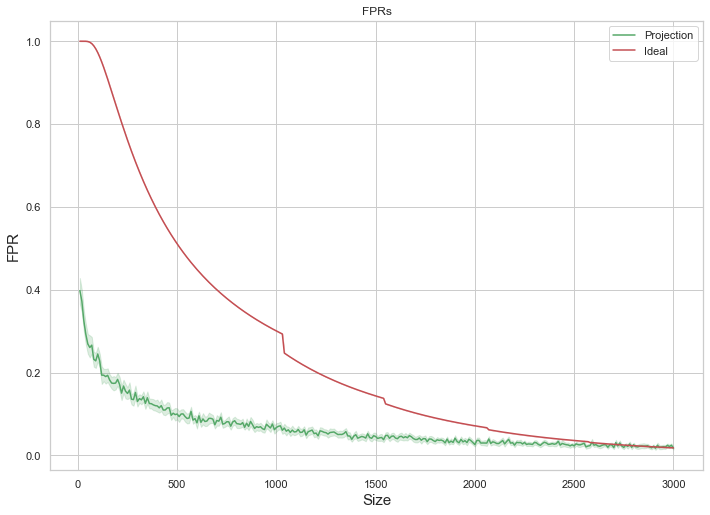

In [62]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [68]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

15000


In [73]:
average_times = num_of_iterations*average_times
print(len(average_times))

15000


In [69]:
print(average_fprs)

[0.3977358490566037, 0.3722641509433962, 0.3247169811320754, 0.2920754716981132, 0.26886792452830194, 0.26037735849056604, 0.26603773584905654, 0.23188679245283025, 0.2281132075471698, 0.24471698113207543, 0.22773584905660382, 0.19358490566037742, 0.1935849056603773, 0.19018867924528307, 0.1932075471698113, 0.18188679245283024, 0.17452830188679244, 0.1737735849056604, 0.17452830188679244, 0.18339622641509437, 0.17113207547169806, 0.15018867924528304, 0.16735849056603777, 0.15490566037735848, 0.149433962264151, 0.15754716981132078, 0.13566037735849054, 0.13452830188679255, 0.15188679245283018, 0.13000000000000003, 0.13698113207547172, 0.13396226415094337, 0.1415094339622642, 0.1254716981132076, 0.13905660377358492, 0.12509433962264155, 0.12471698113207547, 0.12188679245283027, 0.12000000000000004, 0.11924528301886793, 0.1147169811320755, 0.12000000000000002, 0.10943396226415097, 0.10943396226415096, 0.11433962264150946, 0.11490566037735851, 0.09660377358490566, 0.10169811320754722, 0.09

In [74]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.396226,0.397736,0.102308,0.108913
1,20,1.000000,0.330189,0.372264,0.092280,0.106854
2,30,0.999994,0.226415,0.324717,0.095095,0.108138
3,40,0.999881,0.264151,0.292075,0.113087,0.107110
4,50,0.999263,0.349057,0.268868,0.104781,0.105650


In [75]:
df.to_csv('E:\SURA Data\BreastCancer_rerun_epochs_100.csv')